In [35]:
import numpy as np
import gbm
import scipy.stats
import matplotlib.pyplot as plt
import pandas as pd
import os
import glob
import re
from gbm.data import TTE
from gbm.binning.unbinned import bin_by_time
from gbm.background import BackgroundFitter
from gbm.background.binned import Polynomial
from astropy.io import fits


In [36]:
# reduce gbm data
# select the fermi id of the burst
fermi_id = "bn260101039"
energy_range = (8, 1000)  # in keV
bin_time = 0.064  # in seconds
# test if the data is already downloaded by checking if the folder exists
data_folder = f"./{fermi_id}"
if not os.path.exists(data_folder):
    # write a line of code from the terminal to download the data
    os.system(f"../take_GBM_burst_data.sh {fermi_id}")

In [71]:
from astropy.io import fits

filename = file_path_bcat
with fits.open(filename) as hdul:
    # Access the Primary Header (Metadata)
    header = hdul[0].header
    t90 = hdul[0].header['T90']
    t90_start = hdul[0].header['T90START']
    # Print every line ("Card") nicely
    print(f"{'KEYWORD':<10} = {'VALUE':<20} / {'COMMENT'}")
    print("-" * 60)
    
    for card in header.cards:
        print(card)

KEYWORD    = VALUE                / COMMENT
------------------------------------------------------------
SIMPLE  =                    T /Written by IDL:  Thu Jan  1 02:33:26 2026       
BITPIX  =                    8 /                                                
NAXIS   =                    0 /                                                
EXTEND  =                    T /File contains extensions                        
DATE    = '2026-01-01T08:33:27' /                                               
FILETYPE= 'SPECTRAL FITS'      /Unique FITS file type name                      
CREATOR = 'rmfit 4.4.2BA'      /Software/version creating file                  
ORIGIN  = 'GIOC    '           /Name of organization                            
TELESCOP= 'GLAST   '           /Name of mission                                 
INSTRUME= 'GBM     '           /Name of instrument                              
OBSERVER= 'Meegan  '           /Name of instrument PI                           
MJDR

In [72]:
# 1. Search for ANY version of the file (using the * wildcard)
# Replace 'bn120123456' with your specific burst ID
def find_files(search_pattern):
    #search_pattern = f'{fermi_id}/glg_tcat_all_{fermi_id}_v*.fit'
    found_files = glob.glob(search_pattern)

    # 2. Check if we found anything
    if found_files:
        # 3. Sort the list. 
        # Since "v01" comes alphabetically after "v00", the last item is the newest.
        found_files.sort()
        best_file = found_files[-1]
        
        print(f"Using the latest version: {best_file}")
        return best_file 
        # Now you can open 'best_file' to check the detectors
    else:
        #print("No file found!")
        return Exception("No file found!")
file_path_tcat = find_files(f'{fermi_id}/glg_tcat_all_{fermi_id}_v*.fit')

with fits.open(file_path_tcat) as hdul:
    # The mask is usually in the Primary header (index 0)
    det_mask = hdul[0].header['DET_MASK']
    
    print(f"Detector Mask: {det_mask}")

    # Standard GBM Order: 
    # Indices 0-11 are NaI (n0...nb)
    # Indices 12-13 are BGO (b0, b1)
    
    detectors = ['n0','n1','n2','n3','n4','n5','n6','n7','n8','n9','na','nb','b0','b1']
    
    used_detectors = [det for i, det in enumerate(detectors) if det_mask[i] == '1']
    print(f"Used Detectors: {used_detectors}")

file_path_bcat = find_files(f'{fermi_id}/glg_bcat_all_{fermi_id}_v*.fit')
file_path_bcat

Using the latest version: bn260101039/glg_tcat_all_bn260101039_v03.fit
Detector Mask: 10000000010000
Used Detectors: ['n0', 'n9']
Using the latest version: bn260101039/glg_bcat_all_bn260101039_v00.fit


'bn260101039/glg_bcat_all_bn260101039_v00.fit'

In [73]:
tte_files=[]
ttes=[]
for det in used_detectors:
    tte_files.append(find_files(f'{fermi_id}/glg_tte_{det}_{fermi_id}_v*.fit'))
    ttes.append(TTE.open(tte_files[-1]))
tte_files


det_time, det_counts, det_err_counts = [], [], []
for det in ttes:
    phaii = det.to_phaii(bin_by_time, bin_time, time_ref = 0.0)
    lc = phaii.to_lightcurve(energy_range = energy_range)
    counts = lc.counts 
    err_counts = np.sqrt(lc.counts+3/4)+1
    time = lc.centroids
    det_time.append(time)
    det_counts.append(counts)
    det_err_counts.append(err_counts)

Using the latest version: bn260101039/glg_tte_n0_bn260101039_v00.fit
Using the latest version: bn260101039/glg_tte_n9_bn260101039_v00.fit


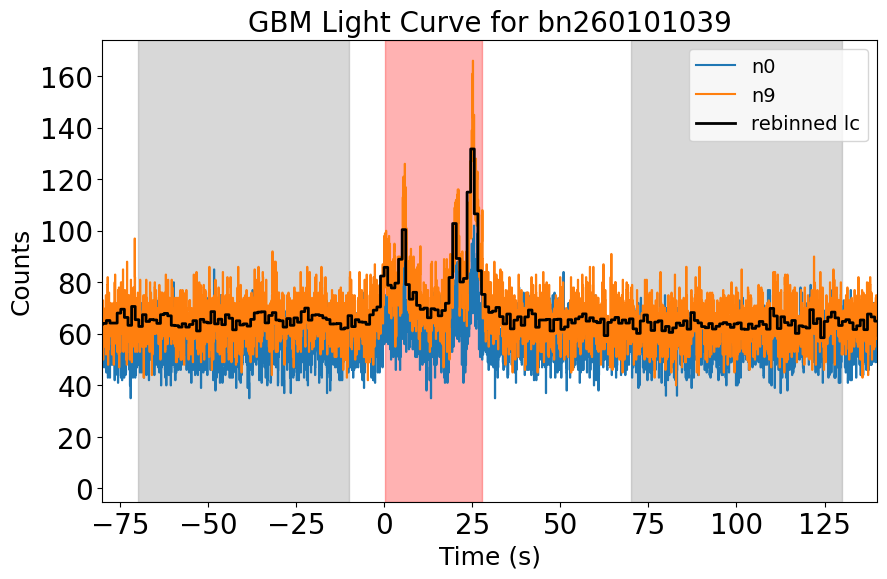

In [150]:
# choose the bkgd intervals
bkgd_intervals = [(-70, -10), (70, 130)]
plt.figure(figsize=(10,6))
# plot the light curve for all used detectors
for i, det in enumerate(used_detectors):
    plt.step(det_time[i], det_counts[i], where='mid', label=det)
plt.xlabel('Time (s)', fontsize=18)
plt.ylabel('Counts', fontsize=18)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)

# rebin the light curve to 1s
import sys
from turtle import bk

from numpy import average 
sys.path.append('/astrodata/romain/')
from sax_utils import rebin_lc_genau

x_reb,y_reb,z_reb = rebin_lc_genau(det_time[-1], det_counts[-1], det_err_counts[-1],16,ren=True)
#y_reb /= 16
#z_reb /= 16
plt.step(x_reb, y_reb, where='mid', label='rebinned lc', color='k', linewidth=2)
plt.axvspan(bkgd_intervals[0][0],bkgd_intervals[0][1], color='gray', alpha=0.3)
plt.axvspan(bkgd_intervals[1][0],bkgd_intervals[1][1], color='gray', alpha=0.3)
plt.axvspan(t90_start, t90_start+t90, color='red', alpha=0.3)
#plt.xlim(t90_start-0.5*t90, t90_start+3*t90)
plt.xlim(bkgd_intervals[0][0]-10, bkgd_intervals[1][1]+10)
plt.title(f'GBM Light Curve for {fermi_id}', fontsize=20)
plt.legend(fontsize=14)


-->  Deg 1 polynomial parameters: [-1.32922469e-02  1.20507587e+02]
Residuals Mean: -0.056349850241787104, Std: 1.2572839892323646


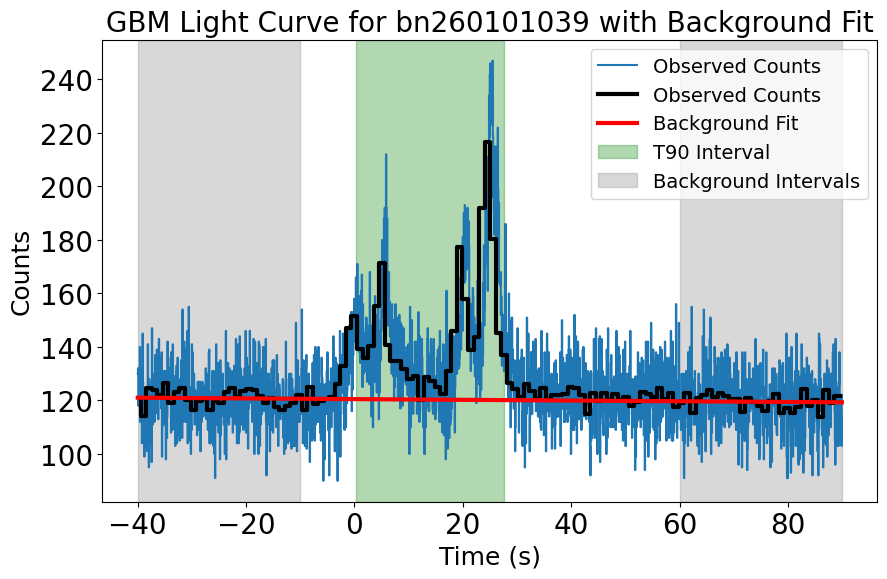

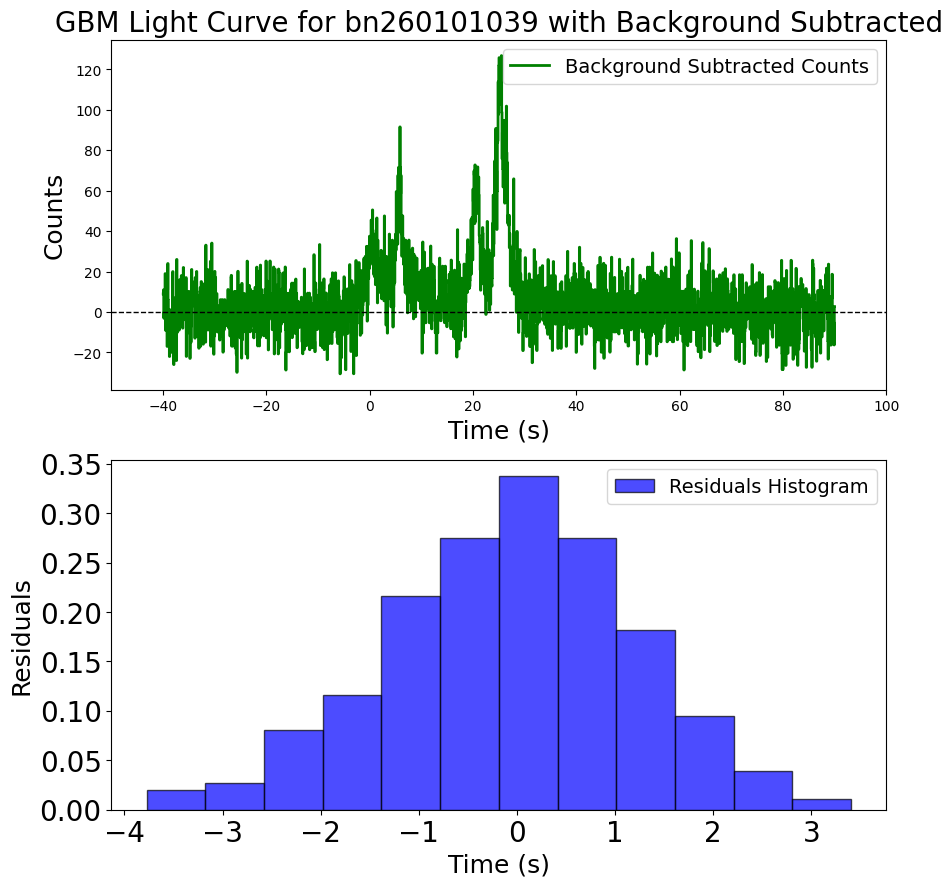

In [ ]:
# sum the counts of all used detectors
time = det_time[0]

counts_tot = np.zeros(len(det_counts[0]))
counts_tot_reb = np.zeros(len(x_reb))
for k in range(len(det_counts)):
    counts_tot+= det_counts[k]
    x_reb_det,y_reb_det,z_reb_det = rebin_lc_genau(det_time[k], det_counts[k], det_err_counts[k],16,ren=True)
    counts_tot_reb += y_reb_det

det_err_counts_tot_squared= np.zeros(len(det_counts[0]))
det_err_counts_tot_squared_reb= np.zeros(len(x_reb))

for k in range(len(det_counts)):
    det_err_counts_tot_squared+= det_err_counts[k]**2
    det_err_counts_tot_squared_reb+= (z_reb_det)**2

err_counts_tot = np.sqrt(det_err_counts_tot_squared)
err_counts_tot_reb = np.sqrt(det_err_counts_tot_squared_reb)

idx_bkgds_reb = np.where( (x_reb > t1) & (x_reb < t2) | (x_reb > t3) & (x_reb < t4) )[0]
time_bkgds_reb,cts_bkgds_reb,err_bkgds_reb = x_reb[idx_bkgds_reb], counts_tot_reb[idx_bkgds_reb], err_counts_tot_reb[idx_bkgds_reb]

idx_cut = np.where( (x_reb > t1) & (x_reb < t4) )[0]
time_cut_reb,counts_tot_cut_reb,err_counts_tot_cut_reb = x_reb[idx_cut], counts_tot_reb[idx_cut], err_counts_tot_reb[idx_cut]


# do the same for the unrebinned data
idx_bkgds = np.where( (time > t1) & (time < t2) | (time > t3) & (time < t4) )[0]
time_bkgds,cts_bkgds,err_bkgds = time[idx_bkgds], counts_tot[idx_bkgds], err_counts_tot[idx_bkgds]
idx_cut = np.where( (time > t1) & (time < t4) )[0]

time_cut,counts_tot_cut,err_counts_tot_cut = time[idx_cut], counts_tot[idx_cut], err_counts[idx_cut]


deg = 1
bin_time_rb = 1.024
p_bg_tot, cov = np.polyfit(time_bkgds_reb,cts_bkgds_reb,deg,w=1/err_bkgds_reb, full = False, cov = True)
print('-->  Deg {0} polynomial parameters:'.format(deg), p_bg_tot)
bg_poly_tot = np.polyval(p_bg_tot, time_cut)
bg_mean = np.mean(bg_poly_tot)

counts_no_bkgd_tot_cut = counts_tot_cut - bg_poly_tot

residuals_tot = counts_no_bkgd_tot_cut/ err_counts_tot_cut

plt.figure(figsize=(10,6))
#plt.step(time_cut, residuals_tot, where='mid', label='Residuals')

plt.step(time_cut,counts_tot_cut, where='mid', label='Observed Counts', markersize=4)
plt.step(time_cut_reb,counts_tot_cut_reb, label='Observed Counts', markersize=4,lw=3,color='k')
plt.plot(time_cut,bg_poly_tot, color='red', label='Background Fit', linewidth=3)
plt.axvspan(t90_start, t90_start+t90, color='green', alpha=0.3,label='T90 Interval')
plt.axvspan(t1, t2, color='gray', alpha=0.3,label='Background Intervals')
plt.axvspan(t3, t4, color='gray', alpha=0.3)
plt.xlabel('Time (s)', fontsize=18)
plt.ylabel('Counts', fontsize=18)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.title(f'GBM Light Curve for {fermi_id} with Background Fit', fontsize=20)
plt.legend(fontsize=14)
# other figure with the bkdg subtracted lc and the residuals (make two panels)
fig,axs = plt.subplots(2,1, figsize=(10,10))
axs[0].step(time_cut, counts_no_bkgd_tot_cut, where='mid', label='Background Subtracted Counts', color='green', linewidth=2)
axs[0].axhline(0, color='black', linestyle='--', linewidth=1)
axs[0].set_ylabel('Counts', fontsize=18)
axs[0].set_xlabel('Time (s)', fontsize=18)
axs[0].set_xlim(t1-10, t4+10)
axs[0].set_title(f'GBM Light Curve for {fermi_id} with Background Subtracted', fontsize=20)

axs[0].legend(fontsize=14)

# take between t1 and t2  or t3 and t4
counts_no_bkgd_tot_cut = counts_tot_cut - bg_poly_tot
counts_no_bkgd_tot_cut2 = counts_no_bkgd_tot_cut[(time_cut > t1) & (time_cut < t2) | (time_cut > t3) & (time_cut < t4)]
err_counts_tot_cut2 = err_counts_tot_cut[(time_cut > t1) & (time_cut < t2) | (time_cut > t3) & (time_cut < t4)]
residuals_tot = counts_no_bkgd_tot_cut2/ err_counts_tot_cut2
axs[1].hist(residuals_tot,bins=12, density=True, alpha=0.7, color='blue', label='Residuals Histogram',edgecolor='black')
#axs[1].axhline(0, color='black', linestyle='--', linewidth=1)
axs[1].set_xlabel('Time (s)', fontsize=18)
axs[1].set_ylabel('Residuals', fontsize=18)
axs[1].legend(fontsize=14)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
# print residuals statistics
mean_res = np.mean(residuals_tot)
std_res = np.std(residuals_tot)
print(f'Residuals Mean: {mean_res}, Std: {std_res}')

0.0625

(array([-50.,   0.,  50., 100., 150., 200., 250., 300.]),
 <a list of 8 Text major ticklabel objects>)

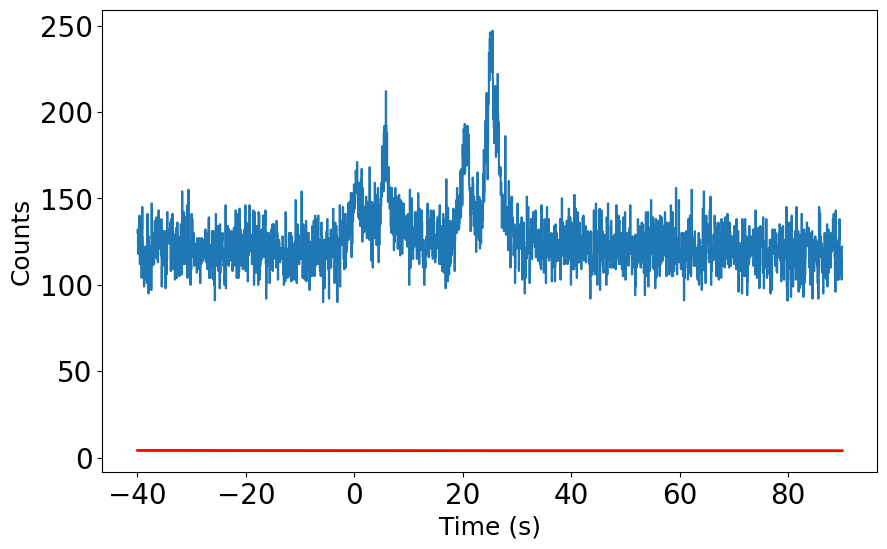